In [1]:
%cd /home/matthandzel/Code/Python/PlayingForager
from PIL.Image import PERSPECTIVE
#from tensorflow.python.framework.ops import add_to_collections
from mapInput import *
from environment import *
from agent import *
from utils import *
from dataManager import Manager
import time, keras, os

class Gym:
  env = Environment()
  manager = Manager()
  
  action_space_size = [5, 2]

  data = []
  
  nEpisodes = 0
  nSteps = 0

  framerate = 5
  actionsArray = []
  
  trainTimes = 10

  explorationRate = 0.95



  def __init__(self, load = True):
    self.agent = Agent(self)

    self.input = Input()
    # input dims = [[68, 135], 3]
    # output dims = 6
    input_vision_dimensions = [50, 50, 1]
    self.agent.define_model(input_vision_dimensions, self.action_space_size)
    stats = self.manager.loadMetadata()
    self.nEpisodes = stats["nEpisodes"]
    self.nSteps = stats["nSteps"]
    if load:
      temp = self.trainTimes
      self.trainTimes = 1
      self.trainOnPrevData(1)
      self.trainTimes = temp
      self.manager.loadPreviousSession(self.agent, self.nEpisodes)
    self.input.run()
    
  
  def initallyTrain(self):
    self.agent.updateTargetModel()
    self.trainOnPrevData(500000)
    input("...")
  
  def trainOnPrevData(self,nSteps):
    totalSteps = 0
    while totalSteps < nSteps:
      print(f"\n{totalSteps}/{nSteps}")
      self.agent.experienceReplay = self.manager.loadRandomSample()
      self.train()
      print(len(self.agent.experienceReplay))
      totalSteps += len(self.agent.experienceReplay) * self.trainTimes
    self.agent.experienceReplay = ReplayExperience(maxlen = 5000)

  def runHeuristic(self):
    while not self.input.terminated:
      self.heuristicEpisode()

  def run(self):
    if(self.trainer == None):
      raise Exception("YOU NEED TO SET THE TRAINER (gym.setTrainer(trainer))")
    while not self.input.terminated:
      print("Starting the episode..")
      self.episode()
      self.betweenEpisodes()
      print("SAVING MODELS...")
      self.manager.saveSession(self.agent, self.nEpisodes)
  
  def betweenEpisodes(self):
    pass

  def updateMetadata(self):
    self.manager.updateMetadata(self.getStats())
  
  def getStats(self):
    return {"nEpisodes" : self.nEpisodes,
            "nSteps" : self.nSteps}

  def episode(self):
    # check if training
    #   - if training:
    #       train
    # check if updating target model
    # update to history
    
    alive = True
    
    start_steps = self.nSteps

    game_data = self.env.getDataFromGame()
    current_state = game_data[0]
    self.nEpisodes += 1

    while alive and not self.input.terminated:
      self.nSteps += 1

      if random.random() > self.explorationRate:
        predictions = self.agent.predictRewardsForActions(current_state)
        actions = [np.argmax(predictions[0]), np.argmax(predictions[1])]
      else:
        actions = [random.randint(0,self.action_space_size[0]-1),random.randint(0,self.action_space_size[1]-1)] 
      
      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.press(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.press(self.input.actionInputs[actions[1]])

      next_game_data = self.env.getDataFromGame()
      next_state = next_game_data[0]

      time.sleep(1/self.framerate)

      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.release(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.release(self.input.actionInputs[actions[1]])
      
      # set data to experience replay
      self.agent.experienceReplay.append([current_state, actions, self.env.computeReward(game_data[1:], next_game_data[1:]), next_state[1] == 0,  next_state])
      print(game_data[1:])
      game_data = next_game_data
      current_state = next_state
      if self.explorationRate > 0.5:
        self.explorationRate *= 0.999998
      
      if game_data[1] == 0:
        alive = False
        if self.nSteps - start_steps >= 10: # This is so that if the episode is really short we dont save it
          self.manager.addEpisode(np.array(self.agent.experienceReplay, dtype=object))
    self.printMetadataOfEpisode(self.agent.experienceReplay)
    self.agent.experienceReplay.clear()
    self.updateMetadata()
    self.resetEnv()
    print("KILLING")

  def showAiPredictions(self):
    current_state = self.env.getDataFromGame()
    predictions = self.agent.predictRewardsForActions(current_state)
    print("MOVEMENT:")
    for i in range(len(predictions[0][0])):
      print(f"\t{self.input.movementInputs[i]}:\t{round(predictions[0][0][i] * 1000) / 1000}")
    print("ACTION:")
    for i in range(len(predictions[1][0])):
      print(f"\t{self.input.actionInputs[i]}:\t{round(predictions[1][0][i] * 1000) / 1000}")
    print("\n")

  def heuristicEpisode(self):
    # check if training
    #   - if training:
    #       train
    # check if updating target model
    # update to history
    
    alive = True
    
    current_state = self.env.getDataFromGame()
    self.nEpisodes += 1

    while alive and not self.input.terminated:
      self.nSteps += 1

      if random.random() > self.explorationRate:
        predictions = self.agent.predictRewardsForActions(current_state)
        actions = [np.argmax(predictions[0]), np.argmax(predictions[1])]
      else:
        actions = [random.randint(0,self.action_space_size[0]-1),random.randint(0,self.action_space_size[1]-1)] 
      
      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.press(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.press(self.input.actionInputs[actions[1]])

      next_game_data = self.env.getDataFromGame()
      next_state = next_game_data[0]

      time.sleep(1/self.framerate) 

      if self.input.movementInputs[actions[0]] != None:
        self.input.keyboard.release(self.input.movementInputs[actions[0]])
      if self.input.actionInputs[actions[1]] != None:
        self.input.keyboard.release(self.input.actionInputs[actions[1]])
      
      # set data to experience replay
      self.agent.experienceReplay.append([current_state, actions, self.env.computeReward(game_data[1:], next_game_data[1:]), next_state[1] == 0,  next_state])
      
      current_state = next_state
      game_data = next_game_data
      if game_data[1] == 0: 
        alive = False
        if(self.nSteps > 5):
          self.manager.addEpisode(np.array(self.agent.experienceReplay, dtype=object))
        self.printMetadataOfEpisode(self.agent.experienceReplay)
        self.agent.experienceReplay.clear()
        self.updateMetadata()
        self.resetEnv()
        print("KILLING")

  def resetEnv(self):
    print("RESETING ENV")
    restarting = True
    delay = 0.35
    self.input.click(delay)
    self.input.mouse.release(mouse.Button.right)
    self.input.mouse.release(mouse.Button.left)
    while restarting:
      while not self.env.checkIfMainScreen():
        print("\nWe not on main screen\n!")
        self.trainer.train(1, 1)
        self.input.keyboard.press('e')
      # self.trainOnPrevData(50000)
      # press play button
      y_offset = 30
      time.sleep(delay * 3)
      self.input.mouse.position = (1116, 425 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay)
      # Press delete button
      self.input.mouse.position = (1819, 399 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay)
      # NO POSITIOn
      #self.input.mouse.position = (1545, 551 + y_offset)
      # YES POSITIOn
      self.input.mouse.position = (1367, 546 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay * 2)
      self.input.mouse.position = (1441, 518 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      # Classic mode
      self.input.mouse.position = (1154, 542 + y_offset)
      # Single island challenge
      # self.input.mouse.position = (1534, 539 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay)
      self.input.mouse.position = (1453, 699 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      time.sleep(delay)
      time.sleep(2.5)
      self.input.mouse.press(mouse.Button.right)
      time.sleep(delay)
      self.input.mouse.release(mouse.Button.right)
      time.sleep(delay)
      self.input.mouse.position = (1256, 350 + y_offset)
      time.sleep(delay)
      self.input.click(delay)
      restarting = False
    print("ENV READY")
  
  def setTrainer(self, trainer):
    self.trainer = trainer

  def endSession(self):
    self.manager.addData(self.data)
  
  def printMetadataOfEpisode(self, episodeData):
    episodeData = np.array(episodeData, dtype=object)
    episodeLength = len(episodeData[:,2])
    print(f"META DATA FOR EPISODE: {self.nEpisodes}")
    print(f"\tMISC:")
    print(f"\t\tNSTEPS: {episodeLength} ({episodeLength * (1/self.framerate)}) seconds")
    print("\tREWARDS:")
    print(f"\t\tTOTAL: {np.sum(episodeData[:,2])}")
    print(f"\t\tAVERAGE: {np.sum(episodeData[:,2])/episodeLength}")
    print(f"\t\tSTD:\t{np.std(episodeData[:,2])}")
    print(f"\t\tMIN: {np.min(episodeData[:,2])}\t\tMAX: {np.max(episodeData[:,2])}")
  
  def train(self):
    print("CURRENTLY TRAINING MODEL...")
    for i in range(self.trainTimes):
      print(f"LOSS {i+1} / {self.trainTimes}: {np.sum(self.agent.train(epochs=1))}")
    print("UPDATING TARGET MODEL")
    self.agent.updateTargetModel()

if __name__ == "__main__":
  gym = Gym(False)

  from trainAi import Trainer
  trainer = Trainer(gym)
  gym.setTrainer(trainer)
  trainer.trainOnAllData(1, 1)
  # try:
  gym.run()
  # except KeyboardInterrupt or Exception or OSError or ValueError as e:
  #   print(e)
  #   gym.input.stopListener()

/home/matthandzel/Code/Python/PlayingForager


/tmp/ipykernel_1032922/3640862435.py:2: DeprecationWarning: PERSPECTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.PERSPECTIVE instead.
  from PIL.Image import PERSPECTIVE
2023-08-27 11:33:11.316387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 11:33:11.452271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-27 11:33:11.452291: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-27 11:33:11.480407: E tensorflow/stream_executor/cuda/cuda

GATHERING DATA...
TRAINING MODEL...
	TIME: 18.4	LOSS 0 / 1: 0.015504596166205583
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0040/assets


INFO:tensorflow:Assets written to: ./models/model_0040/assets


Starting the episode..
[1, 16, 342]
[1, 16, 342]
[1, 16, 342]
[1, 16, 342]
[1, 16, 342]
[1, 16, 342]
[1, 16, 342]
[1, 16, 342]
[1, 15, 349]
[1, 15, 358]
[1, 15, 367]
[1, 15, 371]
[1, 15, 369]
[1, 15, 370]
[1, 15, 371]
[1, 15, 371]
[1, 15, 371]
[1, 14, 371]
[1, 14, 371]
[1, 14, 371]
[1, 14, 371]
[1, 14, 371]
[1, 14, 371]
[1, 14, 371]
[1, 13, 371]
[1, 13, 371]
[1, 13, 371]
[1, 13, 371]
[1, 13, 371]
[1, 13, 371]
[1, 13, 371]
[1, 13, 371]
[1, 13, 371]
[1, 12, 371]
[1, 13, 372]
[1, 12, 375]
[1, 12, 376]
[1, 12, 377]
[1, 12, 377]
[1, 12, 377]
[1, 12, 377]
[1, 12, 377]
[1, 12, 377]
[1, 12, 377]
[1, 12, 377]
[1, 12, 377]
[1, 12, 377]
[1, 11, 5]
[1, 11, 14]
[1, 11, 18]
[1, 11, 21]
[1, 11, 23]
[1, 11, 25]
[1, 11, 25]
[1, 11, 23]
[1, 10, 23]
[1, 10, 23]
[1, 10, 30]
[1, 10, 36]
[1, 10, 41]
[1, 10, 43]
[1, 10, 43]
[1, 10, 44]
[1, 10, 44]
[1, 10, 44]
[1, 10, 44]
[1, 10, 44]
[1, 10, 44]
[1, 10, 44]
[1, 9, 44]
[1, 9, 44]
[1, 9, 44]
[1, 9, 44]
[1, 9, 44]
[1, 9, 44]
[1, 9, 44]
[1, 9, 44]
[1, 9, 44]
[1, 

INFO:tensorflow:Assets written to: ./models/model_0042/assets


INFO:tensorflow:Assets written to: ./models/model_0042/assets


INFO:tensorflow:Assets written to: ./models/model_0052/assets


INFO:tensorflow:Assets written to: ./models/model_0052/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0043/assets


INFO:tensorflow:Assets written to: ./models/model_0043/assets


INFO:tensorflow:Assets written to: ./models/model_0053/assets


INFO:tensorflow:Assets written to: ./models/model_0053/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0044/assets


INFO:tensorflow:Assets written to: ./models/model_0044/assets


INFO:tensorflow:Assets written to: ./models/model_0054/assets


INFO:tensorflow:Assets written to: ./models/model_0054/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0045/assets


INFO:tensorflow:Assets written to: ./models/model_0045/assets


INFO:tensorflow:Assets written to: ./models/model_0055/assets


INFO:tensorflow:Assets written to: ./models/model_0055/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0046/assets


INFO:tensorflow:Assets written to: ./models/model_0046/assets


INFO:tensorflow:Assets written to: ./models/model_0056/assets


INFO:tensorflow:Assets written to: ./models/model_0056/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0047/assets


INFO:tensorflow:Assets written to: ./models/model_0047/assets


INFO:tensorflow:Assets written to: ./models/model_0057/assets


INFO:tensorflow:Assets written to: ./models/model_0057/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0047/assets


INFO:tensorflow:Assets written to: ./models/model_0047/assets


INFO:tensorflow:Assets written to: ./models/model_0058/assets


INFO:tensorflow:Assets written to: ./models/model_0058/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 48
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0048/assets


INFO:tensorflow:Assets written to: ./models/model_0048/assets


INFO:tensorflow:Assets written to: ./models/model_0059/assets


INFO:tensorflow:Assets written to: ./models/model_0059/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 34, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 33, 0]
[3, 32, 0]
[3, 32, 0]
[3, 32, 0

INFO:tensorflow:Assets written to: ./models/model_0050/assets


INFO:tensorflow:Assets written to: ./models/model_0050/assets


INFO:tensorflow:Assets written to: ./models/model_0060/assets


INFO:tensorflow:Assets written to: ./models/model_0060/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0051/assets


INFO:tensorflow:Assets written to: ./models/model_0051/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0052/assets


INFO:tensorflow:Assets written to: ./models/model_0052/assets


INFO:tensorflow:Assets written to: ./models/model_0061/assets


INFO:tensorflow:Assets written to: ./models/model_0061/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0053/assets


INFO:tensorflow:Assets written to: ./models/model_0053/assets


INFO:tensorflow:Assets written to: ./models/model_0062/assets


INFO:tensorflow:Assets written to: ./models/model_0062/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0054/assets


INFO:tensorflow:Assets written to: ./models/model_0054/assets


INFO:tensorflow:Assets written to: ./models/model_0063/assets


INFO:tensorflow:Assets written to: ./models/model_0063/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0055/assets


INFO:tensorflow:Assets written to: ./models/model_0055/assets


INFO:tensorflow:Assets written to: ./models/model_0064/assets


INFO:tensorflow:Assets written to: ./models/model_0064/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0056/assets


INFO:tensorflow:Assets written to: ./models/model_0056/assets


INFO:tensorflow:Assets written to: ./models/model_0065/assets


INFO:tensorflow:Assets written to: ./models/model_0065/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0056/assets


INFO:tensorflow:Assets written to: ./models/model_0056/assets


INFO:tensorflow:Assets written to: ./models/model_0066/assets


INFO:tensorflow:Assets written to: ./models/model_0066/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 57
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0057/assets


INFO:tensorflow:Assets written to: ./models/model_0057/assets


INFO:tensorflow:Assets written to: ./models/model_0067/assets


INFO:tensorflow:Assets written to: ./models/model_0067/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 1]
[3, 37, 3]
[3, 36, 7]
[3, 36, 9]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 12]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 12]
[3, 34, 15]
[3, 34, 15]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 34, 16]
[3, 33, 16]
[3, 33, 16]
[3, 33, 16]
[3,

INFO:tensorflow:Assets written to: ./models/model_0059/assets


INFO:tensorflow:Assets written to: ./models/model_0059/assets


INFO:tensorflow:Assets written to: ./models/model_0068/assets


INFO:tensorflow:Assets written to: ./models/model_0068/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0060/assets


INFO:tensorflow:Assets written to: ./models/model_0060/assets


INFO:tensorflow:Assets written to: ./models/model_0069/assets


INFO:tensorflow:Assets written to: ./models/model_0069/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0061/assets


INFO:tensorflow:Assets written to: ./models/model_0061/assets


INFO:tensorflow:Assets written to: ./models/model_0070/assets


INFO:tensorflow:Assets written to: ./models/model_0070/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0062/assets


INFO:tensorflow:Assets written to: ./models/model_0062/assets


INFO:tensorflow:Assets written to: ./models/model_0071/assets


INFO:tensorflow:Assets written to: ./models/model_0071/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0063/assets


INFO:tensorflow:Assets written to: ./models/model_0063/assets


INFO:tensorflow:Assets written to: ./models/model_0072/assets


INFO:tensorflow:Assets written to: ./models/model_0072/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0064/assets


INFO:tensorflow:Assets written to: ./models/model_0064/assets


INFO:tensorflow:Assets written to: ./models/model_0073/assets


INFO:tensorflow:Assets written to: ./models/model_0073/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0064/assets


INFO:tensorflow:Assets written to: ./models/model_0064/assets


INFO:tensorflow:Assets written to: ./models/model_0074/assets


INFO:tensorflow:Assets written to: ./models/model_0074/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 65
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0065/assets


INFO:tensorflow:Assets written to: ./models/model_0065/assets


INFO:tensorflow:Assets written to: ./models/model_0075/assets


INFO:tensorflow:Assets written to: ./models/model_0075/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 36, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 35, 0]
[3, 34, 3]
[3, 34, 3]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 5]
[3, 33, 4]
[3, 33, 4]
[3, 33, 11]
[3, 33, 19]
[3, 33, 23]
[3, 33, 26]
[3, 32, 27]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 32, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 31, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 30, 28]
[3, 3

INFO:tensorflow:Assets written to: ./models/model_0067/assets


INFO:tensorflow:Assets written to: ./models/model_0067/assets


INFO:tensorflow:Assets written to: ./models/model_0076/assets


INFO:tensorflow:Assets written to: ./models/model_0076/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0068/assets


INFO:tensorflow:Assets written to: ./models/model_0068/assets


INFO:tensorflow:Assets written to: ./models/model_0077/assets


INFO:tensorflow:Assets written to: ./models/model_0077/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0069/assets


INFO:tensorflow:Assets written to: ./models/model_0069/assets


INFO:tensorflow:Assets written to: ./models/model_0078/assets


INFO:tensorflow:Assets written to: ./models/model_0078/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0070/assets


INFO:tensorflow:Assets written to: ./models/model_0070/assets


INFO:tensorflow:Assets written to: ./models/model_0079/assets


INFO:tensorflow:Assets written to: ./models/model_0079/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0071/assets


INFO:tensorflow:Assets written to: ./models/model_0071/assets


INFO:tensorflow:Assets written to: ./models/model_0080/assets


INFO:tensorflow:Assets written to: ./models/model_0080/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0072/assets


INFO:tensorflow:Assets written to: ./models/model_0072/assets


INFO:tensorflow:Assets written to: ./models/model_0081/assets


INFO:tensorflow:Assets written to: ./models/model_0081/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0072/assets


INFO:tensorflow:Assets written to: ./models/model_0072/assets


INFO:tensorflow:Assets written to: ./models/model_0082/assets


INFO:tensorflow:Assets written to: ./models/model_0082/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 73
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0073/assets


INFO:tensorflow:Assets written to: ./models/model_0073/assets


INFO:tensorflow:Assets written to: ./models/model_0083/assets


INFO:tensorflow:Assets written to: ./models/model_0083/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 2]
[3, 38, 3]
[3, 38, 4]
[3, 38, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 37, 6]
[3, 36, 8]
[3, 36, 9]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 36, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 35, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 34, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 33, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 32, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10]
[3, 31, 10

INFO:tensorflow:Assets written to: ./models/model_0075/assets


INFO:tensorflow:Assets written to: ./models/model_0075/assets


INFO:tensorflow:Assets written to: ./models/model_0084/assets


INFO:tensorflow:Assets written to: ./models/model_0084/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0076/assets


INFO:tensorflow:Assets written to: ./models/model_0076/assets


INFO:tensorflow:Assets written to: ./models/model_0085/assets


INFO:tensorflow:Assets written to: ./models/model_0085/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0077/assets


INFO:tensorflow:Assets written to: ./models/model_0077/assets


INFO:tensorflow:Assets written to: ./models/model_0086/assets


INFO:tensorflow:Assets written to: ./models/model_0086/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0078/assets


INFO:tensorflow:Assets written to: ./models/model_0078/assets


INFO:tensorflow:Assets written to: ./models/model_0087/assets


INFO:tensorflow:Assets written to: ./models/model_0087/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0079/assets


INFO:tensorflow:Assets written to: ./models/model_0079/assets


INFO:tensorflow:Assets written to: ./models/model_0088/assets


INFO:tensorflow:Assets written to: ./models/model_0088/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0080/assets


INFO:tensorflow:Assets written to: ./models/model_0080/assets


INFO:tensorflow:Assets written to: ./models/model_0089/assets


INFO:tensorflow:Assets written to: ./models/model_0089/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0081/assets


INFO:tensorflow:Assets written to: ./models/model_0081/assets


INFO:tensorflow:Assets written to: ./models/model_0090/assets


INFO:tensorflow:Assets written to: ./models/model_0090/assets


ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0081/assets


INFO:tensorflow:Assets written to: ./models/model_0081/assets


INFO:tensorflow:Assets written to: ./models/model_0091/assets


INFO:tensorflow:Assets written to: ./models/model_0091/assets


Starting the episode..
[0, 40, 0]
META DATA FOR EPISODE: 82
	MISC:
		NSTEPS: 1 (0.2) seconds
	REWARDS:
		TOTAL: -0.01
		AVERAGE: -0.01
		STD:	0.0
		MIN: -0.01		MAX: -0.01
RESETING ENV
ENV READY
KILLING
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0082/assets


INFO:tensorflow:Assets written to: ./models/model_0082/assets


INFO:tensorflow:Assets written to: ./models/model_0092/assets


INFO:tensorflow:Assets written to: ./models/model_0092/assets


Starting the episode..
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 38, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 0]
[3, 37, 2]
[3, 37, 3]
[3, 37, 4]
[3, 37, 4]
[3, 37, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 36, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 35, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 34, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 33, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 32, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 31, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4]
[3, 30, 4

INFO:tensorflow:Assets written to: ./models/model_0084/assets


INFO:tensorflow:Assets written to: ./models/model_0084/assets


INFO:tensorflow:Assets written to: ./models/model_0093/assets


INFO:tensorflow:Assets written to: ./models/model_0093/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0085/assets


INFO:tensorflow:Assets written to: ./models/model_0085/assets


INFO:tensorflow:Assets written to: ./models/model_0094/assets


INFO:tensorflow:Assets written to: ./models/model_0094/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0086/assets


INFO:tensorflow:Assets written to: ./models/model_0086/assets


INFO:tensorflow:Assets written to: ./models/model_0095/assets


INFO:tensorflow:Assets written to: ./models/model_0095/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0087/assets


INFO:tensorflow:Assets written to: ./models/model_0087/assets


INFO:tensorflow:Assets written to: ./models/model_0096/assets


INFO:tensorflow:Assets written to: ./models/model_0096/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0088/assets


INFO:tensorflow:Assets written to: ./models/model_0088/assets


Stopping the listener...


INFO:tensorflow:Assets written to: ./models/model_0097/assets


INFO:tensorflow:Assets written to: ./models/model_0097/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0089/assets


INFO:tensorflow:Assets written to: ./models/model_0089/assets


INFO:tensorflow:Assets written to: ./models/model_0098/assets


INFO:tensorflow:Assets written to: ./models/model_0098/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0090/assets


INFO:tensorflow:Assets written to: ./models/model_0090/assets


INFO:tensorflow:Assets written to: ./models/model_0099/assets


INFO:tensorflow:Assets written to: ./models/model_0099/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0091/assets


INFO:tensorflow:Assets written to: ./models/model_0091/assets


INFO:tensorflow:Assets written to: ./models/model_0100/assets


INFO:tensorflow:Assets written to: ./models/model_0100/assets



We not on main screen
!
CURRENTLY TRAINING MODEL...
list index out of range
UPDATING TARGET MODEL
SAVING MODELS...


In [19]:
from trainAi import Trainer
trainer = Trainer(gym)
trainer.trainOnAllData(2, 1)


GATHERING DATA...
TRAINING MODEL...
	TIME: 15.1	LOSS 0 / 2: 0.0033992369584613614
	TIME: 28.3	LOSS 1 / 2: 0.0031787154862040817
SAVING MODELS...


INFO:tensorflow:Assets written to: ./models/model_0019/assets


INFO:tensorflow:Assets written to: ./models/model_0019/assets


In [12]:
offset = 0
while os.path.exists(f"./models/model_{formatNumbersWithZeros(1 + offset, 4)}"):
  offset += 1
  # agent.model.save(f"./models/model_{formatNumbersWithZeros(1 + offset, 4)}")
os.mkdir(f"./models/model_{formatNumbersWithZeros(1 + offset, 4)}/")
print(offset)

40


                                                     0       1     2  \
406  [[0.1322, 0.1322, 0.1322, 0.1322, 0.1322, 0.13...  [4, 1]  0.29   
284  [[0.1753, 0.1783, 0.1783, 0.1771, 0.1744, 0.16...  [2, 1]  0.29   
331  [[0.1687, 0.1687, 0.1764, 0.2195, 0.2454, 0.27...  [4, 0]  0.24   
405  [[0.1322, 0.1322, 0.1322, 0.1322, 0.1322, 0.13...  [0, 0]  0.24   
407  [[0.1484, 0.1384, 0.1322, 0.1322, 0.1322, 0.13...  [4, 1]  0.19   

                                                     3  \
406  [False, False, False, False, False, False, Fal...   
284  [False, False, False, False, False, False, Fal...   
331  [False, False, False, False, False, False, Fal...   
405  [False, False, False, False, False, False, Fal...   
407  [False, False, False, False, False, False, Fal...   

                                                     4  
406  [[0.1484, 0.1384, 0.1322, 0.1322, 0.1322, 0.13...  
284  [[0.1753, 0.1783, 0.1783, 0.1783, 0.1682, 0.16...  
331  [[0.1687, 0.1598, 0.1602, 0.1598, 0.1561, 

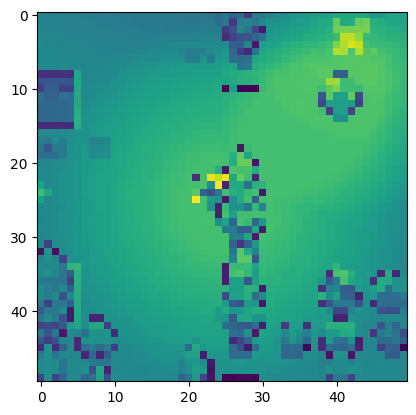

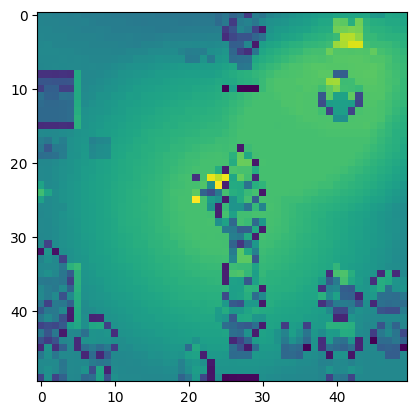

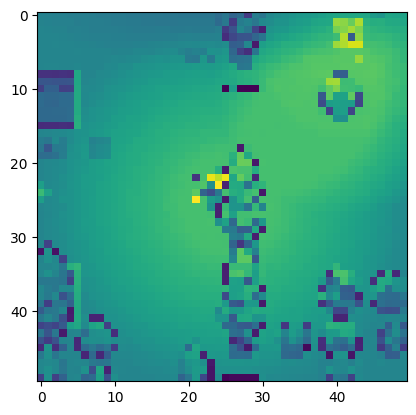

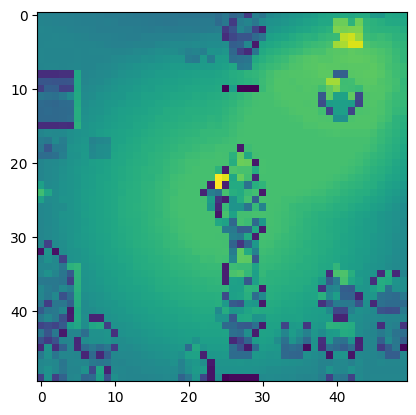

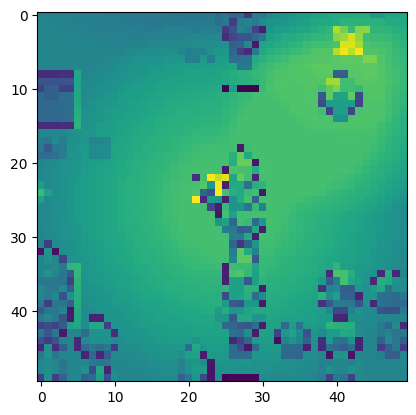

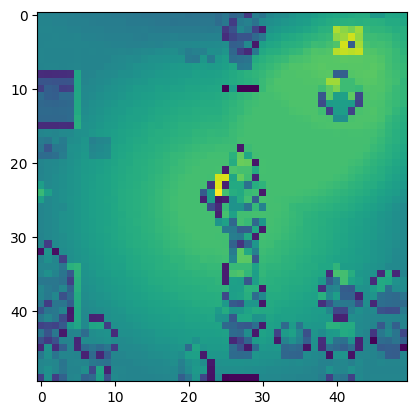

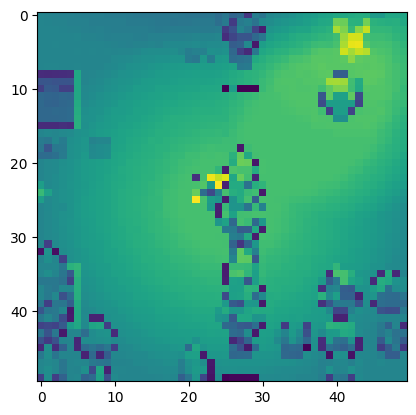

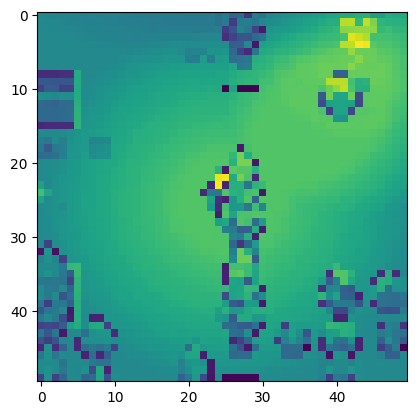

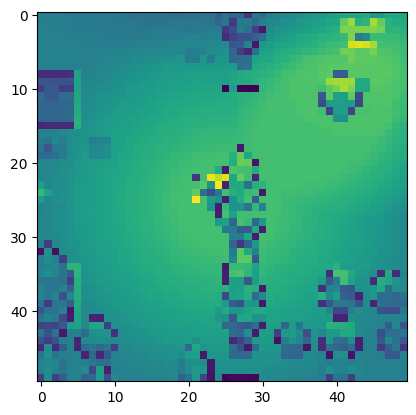

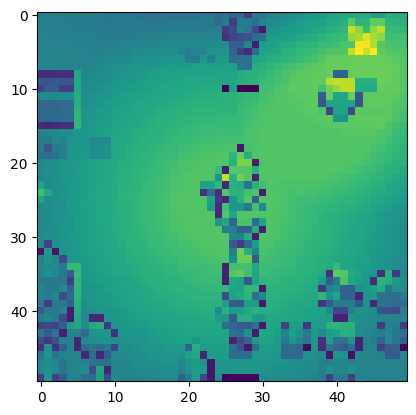

In [58]:
import pandas as pd
df = pd.DataFrame(gym.manager.loadRandomSample())
df = df.sort_values(2, ascending=False)
print(df.head(5))
for i in range(10):
  plt.imshow(df[0][i])

  plt.show()

In [49]:
data[0]

array([array([[array([[0.3315, 0.3315, 0.3315, ..., 0.3315, 0.3315, 0.3315],
                      [0.3315, 0.3315, 0.3315, ..., 0.3325, 0.3325, 0.3325],
                      [0.3315, 0.3315, 0.3315, ..., 0.3315, 0.3315, 0.3315],
                      ...,
                      [0.3315, 0.3315, 0.3315, ..., 0.3315, 0.3315, 0.2935],
                      [0.3315, 0.3315, 0.3315, ..., 0.3328, 0.2822, 0.3274],
                      [0.3315, 0.3315, 0.3315, ..., 0.285 , 0.3315, 0.2754]],
                     dtype=float16)                                          ,
               list([3, 0]), -0.01,
               array([False, False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False, False, False, False,
                      False, False, False, False, False, False, False, False, False,
                      False, False, False, False, False

In [47]:
df.head()

KeyboardInterrupt: 

In [ ]:
gym.trainOnPrevData(10000)

2023-08-27 11:09:42.580896: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops_fused_impl.h:719 : INVALID_ARGUMENT: input must be 4-dimensional[1,50,50]


InvalidArgumentError: Graph execution error:

Detected at node 'model/conv2d/BiasAdd' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_619753/1641384902.py", line 6, in <cell line: 6>
      prediction = gym.agent.predictRewardsForActions(state)
    File "/home/matthandzel/Code/Python/PlayingForager/src/agent.py", line 191, in predictRewardsForActions
      return self.model.predict(np.expand_dims(state,0), verbose=0)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/layers/convolutional/base_conv.py", line 304, in call
      outputs = tf.nn.bias_add(
Node: 'model/conv2d/BiasAdd'
input must be 4-dimensional[1,50,50]
	 [[{{node model/conv2d/BiasAdd}}]] [Op:__inference_predict_function_67693]

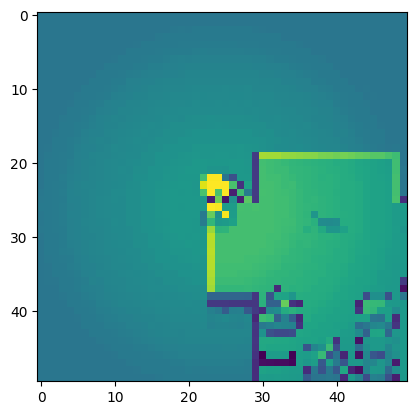

In [21]:
states = gym.manager.loadRandomSample(seed=time.time())
state = states[random.randint(0, len(states)-1)][0]
plt.imshow(state)

prediction = gym.agent.predictRewardsForActions(state)
print(prediction[0])
print(prediction[1])

if np.argmax(prediction[0]) == 0:
    print("AI wants to move right")
elif np.argmax(prediction[0]) == 1:
    print("AI wants to move left")
elif np.argmax(prediction[0]) == 2:
    print("AI wants to move up")
elif np.argmax(prediction[0]) == 3:
    print("AI wants to move down")
else:
    print("AI wants to do nothing")

if np.argmax(prediction[1]) == 0:
    print("AI wants to mine")
elif np.argmax(prediction[1]) == 1:
    print("AI wants to do nothing")